In [17]:
dataset_dir =r"C:/Users/User/Desktop/rakin2/insulator-segmentation/"
csv_file = '/home/rakin/Desktop/segment/artifacts/train_data.csv'  # Update with the actual path
import os 

In [18]:
imag_dir = os.path.join(dataset_dir,'images/polymer')
mask_dir = os.path.join(dataset_dir,'mask/polymer')
print(imag_dir, mask_dir)
print(len(os.listdir(imag_dir)))
print(len(os.listdir(mask_dir)))
assert len(os.listdir(mask_dir)) == len(os.listdir(imag_dir))



C:/Users/User/Desktop/rakin2/insulator-segmentation/images/polymer C:/Users/User/Desktop/rakin2/insulator-segmentation/mask/polymer
15761
15761


In [19]:

images_dir_list = []
mask_dir_list = []
for i in os.listdir(imag_dir): 
    images_dir_list.append(os.path.join(imag_dir,i))
    mask_dir_list.append(os.path.join(mask_dir,i))
    


In [20]:
import pandas as pd 
from PIL.Image import open
from torchmetrics.segmentation import MeanIoU , GeneralizedDiceScore 
from torchmetrics.classification import BinaryAccuracy,BinaryJaccardIndex
from Seg.utils.common import read_yaml
from Seg.utils.logger import logger
from tqdm import tqdm
import matplotlib.pyplot as plt 
import torch
import albumentations as A
import numpy as np
import datetime as dt 
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from  Seg.components.models import  model_list , R2U_Net,AttU_Net
#config = read_yaml(r"Desktop/segment/config/config.yaml")
date_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
logger.info(f"date_time: {date_time}")

# criterion = torch.nn.BCEWithLogitsLoss()
#criterion = torch.nn.CrossEntropyLoss()
criterion = smp.losses.DiceLoss(mode='binary')
# focal loss
#criterion = smp.losses.FocalLoss(mode='binary',gamma=1.0)
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
BinaryJaccardIndex_Score = BinaryJaccardIndex().to('cuda')

[2025-02-13 15:37:21,764: INFO: 3804955329: date_time: 20250213-153721]


In [21]:
Train_config = {
  "device" : "cuda",
  "batch_size" : 6,
  "epochs" : 20,
  "lr" : 0.001,
  "loss" : "dice_loss" #dice_loss
}

Model_config = {
    "model_name" : "unet",
    "backbone" : "resnet34", #resnet34
    "weights" : "imagenet",
    "in_channels" : 3 
}

Transform_config = {
    #train transform config 
   "image_size" : 512, 
   "shift_limit" : 0.2,
   "scale_limit" : 0.2,
   "rotate_limit" : 30,
   "ShiftScaleRotate_p" : 0.5, 
   "r_shift_limit" : 25,
   "g_shift_limit" : 25,
   "b_shift_limit" : 25,
   "RGB_Shift_p" : 0.5,
   "brightness_limit" : 0.3, 
   "contrast_limit" : 0.3,
   "RandomBrightnessContrast_p" : 0.5
}
Data_injection = {
    "seed" : 42, 
    "dataset_dir" : "Desktop/rakin2/segment/artifacts/dataset.csv",
    "train_csv_dir" : "Desktop/rakin2/segment/artifacts/train_data.csv",
    "test_csv_dir" : "Desktop/rakin2/segment/artifacts/test_data.csv",
    "val_csv_dir" : "Desktop/rakin2/segment/artifacts/val_data.csv"
}


In [22]:
train_config=Train_config
model_config=Model_config
transform_config=Transform_config
data_injecton_config =Data_injection
logger.info(f"train_config: {train_config}") 
logger.info(f"model_config: {model_config}")
logger.info(f"transform_config: {transform_config}")
logger.info(f"data_injecton_config: {data_injecton_config}")



[2025-02-13 15:37:21,809: INFO: 342151172: train_config: {'device': 'cuda', 'batch_size': 6, 'epochs': 20, 'lr': 0.001, 'loss': 'dice_loss'}]
[2025-02-13 15:37:21,810: INFO: 342151172: model_config: {'model_name': 'unet', 'backbone': 'resnet34', 'weights': 'imagenet', 'in_channels': 3}]
[2025-02-13 15:37:21,811: INFO: 342151172: transform_config: {'image_size': 512, 'shift_limit': 0.2, 'scale_limit': 0.2, 'rotate_limit': 30, 'ShiftScaleRotate_p': 0.5, 'r_shift_limit': 25, 'g_shift_limit': 25, 'b_shift_limit': 25, 'RGB_Shift_p': 0.5, 'brightness_limit': 0.3, 'contrast_limit': 0.3, 'RandomBrightnessContrast_p': 0.5}]
[2025-02-13 15:37:21,812: INFO: 342151172: data_injecton_config: {'seed': 42, 'dataset_dir': 'Desktop/rakin2/segment/artifacts/dataset.csv', 'train_csv_dir': 'Desktop/rakin2/segment/artifacts/train_data.csv', 'test_csv_dir': 'Desktop/rakin2/segment/artifacts/test_data.csv', 'val_csv_dir': 'Desktop/rakin2/segment/artifacts/val_data.csv'}]


(-0.5, 511.5, 511.5, -0.5)

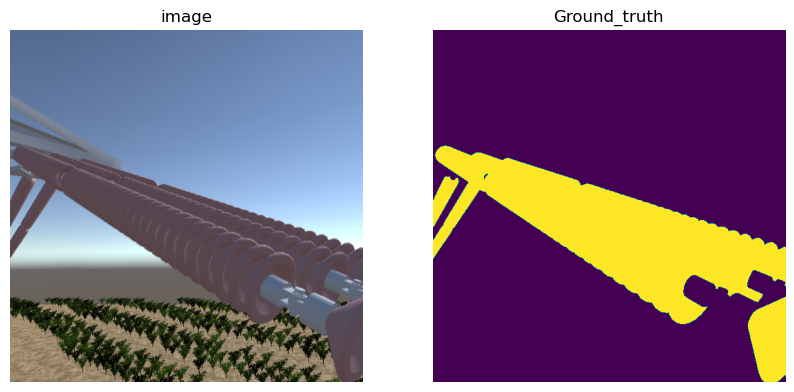

In [23]:


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,8))
ax1.imshow(open(images_dir_list[2]))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(open(mask_dir_list[2]))
ax2.set_title('Ground_truth')
ax2.axis('off')


In [24]:
x=pd.DataFrame({'imag_dir_list': images_dir_list , 'mask_dir_list':mask_dir_list})

In [25]:
x.to_csv('dataset.csv')

In [26]:

from PIL import Image
from torch.utils.data import Dataset



class SegmentDataset(Dataset):
    """
    DroneDataset class for loading the dataset with one-hot encoded masks.

    Args:
        img_path: Path to the images directory.
        mask_path: Path to the masks directory.
        X: List of image names.
        transform: Data augmentation transformations.

    Returns:
        image: Image tensor.
        mask: One-hot encoded mask tensor.
    """

    def __init__(self, csv_path , num_classes=2, transform=None):
        self.dataset = pd.read_csv(csv_path)
        self.img_path = self.dataset['imag_dir_list']
        self.mask_path = self.dataset['mask_dir_list']
        self.num_classes = num_classes  # Number of classes for one-hot encoding
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load image and mask
        image = np.array(Image.open(self.img_path[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_path[idx]).convert("L"))  # Grayscale mask

        # Apply Albumentations transformations (if any)
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # One-hot encode the mask
        mask_one_hot = np.zeros((mask.shape[0], mask.shape[1], self.num_classes), dtype=np.float32)
        
        # Create one-hot encoding using the unique values in the mask
        for i, unique_value in enumerate(np.unique(mask)):
            mask_one_hot[:, :, i][mask == unique_value] = 1
        
        # Normalize the image using Albumentations Normalize
        norm = A.Normalize(mean=(0 ,0, 0), std=(1, 1, 1))(image=image, mask=mask_one_hot)
        
        # Return image and one-hot encoded mask as tensors in [C, H, W] format
        return norm["image"].transpose(2, 0, 1), norm["mask"].transpose(2, 0, 1).astype("float32")



In [27]:

class DataInjection():
    def __init__(self , Dataset_dir) -> None:
        self.dataset = pd.read_csv(Dataset_dir)
        #self.injection_config = config["Data_injection"]
        

    def inject(self):
        logger.info('data injection started')
        if 'Unnamed: 0' in self.dataset.columns:
            dataset_cleaned = self.dataset.drop(columns=['Unnamed: 0'])
        else:
            dataset_cleaned = self.dataset

        logger.info('train data spliting ')
        train_data, temp_data = train_test_split(dataset_cleaned, test_size=0.2, random_state=42)
        logger.info('val test spliting ')
        val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

        logger.info('csv saving started')   
        train_data.to_csv('train_data.csv', index=False)
        logger.info('train csv done ')
        val_data.to_csv('val_data.csv', index=False)
        logger.info('val csv done ')
        test_data.to_csv('test_data.csv', index=False)
        logger.info('test csv done')


In [28]:
dInj = DataInjection("C:/Users/User/Desktop/rakin2/segment/notebook/dataset.csv")
dInj.inject()

[2025-02-13 15:37:22,155: INFO: 3993860970: data injection started]
[2025-02-13 15:37:22,157: INFO: 3993860970: train data spliting ]
[2025-02-13 15:37:22,159: INFO: 3993860970: val test spliting ]
[2025-02-13 15:37:22,161: INFO: 3993860970: csv saving started]
[2025-02-13 15:37:22,214: INFO: 3993860970: train csv done ]
[2025-02-13 15:37:22,221: INFO: 3993860970: val csv done ]
[2025-02-13 15:37:22,228: INFO: 3993860970: test csv done]


In [29]:



def model_selection(model_name: str, model_encoder: str, weight: str):
    """
    arg:
      model_name(str) name of the model
      model_encoder(str) : name of the encoder used


    return : model object with given encoder

    """

    model = smp.create_model(
        arch=model_name,  # name of the architecture, e.g. 'Unet'/ 'FPN' / etc. Case INsensitive!
        encoder_name=model_encoder,
        encoder_weights=weight,
        in_channels=3,
        classes=2,
    )

    return model



transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
    ])
   

In [30]:
model = model_selection(Model_config['model_name'], Model_config['backbone'],Model_config['weights'])
model=model.to('cuda')
#model = AttU_Net(3,2).to('cuda')


In [31]:
Train_DL_config = {
    "train_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/train_data.csv",
    "batch_size": 6,
    "num_workers": 4,
    "shuffle": True
}

Val_DL_config = {
    "val_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/val_data.csv",
    "batch_size": 2,
    "num_workers": 4,
    "shuffle": False,
    "transform": True,
    "random_blur": False
}

Test_DL_config = {
    # setting to val as test dir is corrupted in local drive
   "test_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/test_data.csv",
   "batch_size": 2,
   "num_workers": 4,
   "shuffle": False,
   "transform": True
}

In [32]:

train_data = SegmentDataset(Train_DL_config['train_dirs'],2,transform=transform )
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=Train_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])
test_data = SegmentDataset(Test_DL_config['test_dirs'],2,transform=transform )
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=Test_DL_config['batch_size'], shuffle=Test_DL_config['shuffle'])
val_data = SegmentDataset(Val_DL_config['val_dirs'],2,transform=transform )
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=Val_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=train_config['lr'])

mean_iou_score_for_training = []
dice_score_for_training =[]
accuracy_for_training = []
train_loss=[]
binary_jaccard_index_for_training = []

mean_iou_score = []
dice_score =[]
accuracy = []
val_loss =[]
binary_jaccard_index = []

for epoch in range(train_config['epochs']):    
    model.train()
    total_losses = 0
    pbar = tqdm(enumerate(train_dataloader), total = len(train_dataloader),colour='green')
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat,y)
    
        loss.backward()
        optimizer.step()
        total_losses += loss.item()
        jeq_indx_for_training = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou_for_training = IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values_for_training = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc_for_training = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score_for_training.append(mean_miou_for_training)
        binary_jaccard_index_for_training.append(jeq_indx_for_training)
        dice_score_for_training.append(dice_score_values_for_training)
        accuracy_for_training.append(acc_for_training)
        train_loss.append(total_losses/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"train_loss": total_losses / (i + 1) , 
                                  "train_Miou_score": sum(mean_iou_score_for_training)/len(mean_iou_score_for_training) ,
                                    "train_dice_score" : sum(dice_score_for_training)/len(dice_score_for_training),
                                   "train_acc": sum(accuracy_for_training)/len(accuracy_for_training),
                                   "train_binary_jaccard_index": sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training)} )

    # mlflow metrics
    #mlflow.log_metric("train_loss", sum(train_loss) / len(train_loss), step=epoch)
    logger.info(f"Epoch: {epoch} | Training_Loss: {total_losses / len(train_dataloader)}")
    logger.info(f"train_binary_jaccard_index: {sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training)}")
    # mlflow metrics
    logger.info(f"train_loss {sum(train_loss) / len(train_loss) }")
    logger.info(f"train_Miou_score {sum(mean_iou_score_for_training)/len(mean_iou_score_for_training)}" )
    logger.info(f"train_dice_score {sum(dice_score_for_training)/len(dice_score_for_training)}" )
    logger.info(f"train_acc {sum(accuracy_for_training)/len(accuracy_for_training)}" )

    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()
    
    total_loss = 0.0
    model.eval()
 
    pbar = tqdm(enumerate(val_dataloader), total=len(val_dataloader),colour="blue")
    
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        y_hat = model(x)
        loss = criterion(y_hat, y)
    
        total_loss += loss.item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)
        binary_jaccard_index.append(jeq_indx)
        dice_score.append(dice_score_values)
        accuracy.append(acc)
        val_loss.append(total_loss/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"eval_loss": total_loss / (i + 1) , 
                                  "eval_Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                                    "eval_dice_score" : sum(dice_score)/len(dice_score),
                                   "eval_acc": sum(accuracy)/len(accuracy),
                                   "eval_binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index)} )
        
        #save model  if val loss is minimum
        
        

    #torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin/segment/artifacts/model_ckpt/unet_{date_time}.pth')
    
    logger.info(f"Epoch: {epoch} | Loss: {total_loss / len(val_dataloader)}")
    logger.info(f"eval_binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    # mlflow metrics
    logger.info(f"eval_loss {sum(val_loss) / len(val_loss) }")
    logger.info(f"eval_Miou_score {sum(mean_iou_score)/len(mean_iou_score)}" )
    logger.info(f"eval_dice_score {sum(dice_score)/len(dice_score)}" )
    logger.info(f"eval_acc {sum(accuracy)/len(accuracy)}" )
    
    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()

100%|██████████| 2102/2102 [09:12<00:00,  3.80it/s, epoch=0, train_loss=0.0259, train_Miou_score=0.48, train_dice_score=0.696, train_acc=0.98, train_binary_jaccard_index=0.869]  

[2025-02-13 15:46:35,571: INFO: 2245122998: Epoch: 0 | Training_Loss: 0.025878216940147553]
[2025-02-13 15:46:35,572: INFO: 2245122998: train_binary_jaccard_index: 0.8689937771578895]
[2025-02-13 15:46:35,573: INFO: 2245122998: train_loss 0.05975134420407443]
[2025-02-13 15:46:35,573: INFO: 2245122998: train_Miou_score 0.48013030823415853]
[2025-02-13 15:46:35,574: INFO: 2245122998: train_dice_score 0.6963332599652781]
[2025-02-13 15:46:35,575: INFO: 2245122998: train_acc 0.9801086724002966]



100%|██████████| 788/788 [01:10<00:00, 11.12it/s, epoch=0, eval_loss=0.0121, eval_Miou_score=0.496, eval_dice_score=0.77, eval_acc=0.988, eval_binary_jaccard_index=0.911] 

[2025-02-13 15:47:46,454: INFO: 2245122998: Epoch: 0 | Loss: 0.012082092879992451]
[2025-02-13 15:47:46,454: INFO: 2245122998: eval_binary_jaccard_index: 0.9112817543903886]
[2025-02-13 15:47:46,455: INFO: 2245122998: eval_loss 0.011148878441656457]
[2025-02-13 15:47:46,455: INFO: 2245122998: eval_Miou_score 0.49608936240225276]
[2025-02-13 15:47:46,456: INFO: 2245122998: eval_dice_score 0.7703053952776237]
[2025-02-13 15:47:46,457: INFO: 2245122998: eval_acc 0.9880872208454887]



100%|██████████| 2102/2102 [06:01<00:00,  5.82it/s, epoch=1, train_loss=0.00884, train_Miou_score=0.498, train_dice_score=0.744, train_acc=0.986, train_binary_jaccard_index=0.903]

[2025-02-13 15:53:47,917: INFO: 2245122998: Epoch: 1 | Training_Loss: 0.008844973925291981]
[2025-02-13 15:53:47,918: INFO: 2245122998: train_binary_jaccard_index: 0.9029426289213685]
[2025-02-13 15:53:47,918: INFO: 2245122998: train_loss 0.03480776420108123]
[2025-02-13 15:53:47,919: INFO: 2245122998: train_Miou_score 0.4975276294844021]
[2025-02-13 15:53:47,919: INFO: 2245122998: train_dice_score 0.7442315013748687]
[2025-02-13 15:53:47,920: INFO: 2245122998: train_acc 0.9856973921438833]



100%|██████████| 788/788 [00:46<00:00, 17.05it/s, epoch=1, eval_loss=0.00949, eval_Miou_score=0.502, eval_dice_score=0.778, eval_acc=0.989, eval_binary_jaccard_index=0.919]

[2025-02-13 15:54:34,146: INFO: 2245122998: Epoch: 1 | Loss: 0.009486444029711225]
[2025-02-13 15:54:34,146: INFO: 2245122998: eval_binary_jaccard_index: 0.9186931007818276]
[2025-02-13 15:54:34,147: INFO: 2245122998: eval_loss 0.010441944398257203]
[2025-02-13 15:54:34,147: INFO: 2245122998: eval_Miou_score 0.5022180233943172]
[2025-02-13 15:54:34,148: INFO: 2245122998: eval_dice_score 0.7779808865900288]
[2025-02-13 15:54:34,149: INFO: 2245122998: eval_acc 0.9893390139952529]



100%|██████████| 2102/2102 [05:59<00:00,  5.85it/s, epoch=2, train_loss=0.00795, train_Miou_score=0.504, train_dice_score=0.765, train_acc=0.988, train_binary_jaccard_index=0.916]

[2025-02-13 16:00:33,672: INFO: 2245122998: Epoch: 2 | Training_Loss: 0.007951665673224162]
[2025-02-13 16:00:33,673: INFO: 2245122998: train_binary_jaccard_index: 0.9162885970833318]
[2025-02-13 16:00:33,673: INFO: 2245122998: train_loss 0.026035284748722166]
[2025-02-13 16:00:33,673: INFO: 2245122998: train_Miou_score 0.5044871517095232]
[2025-02-13 16:00:33,674: INFO: 2245122998: train_dice_score 0.7646194327125828]
[2025-02-13 16:00:33,675: INFO: 2245122998: train_acc 0.9878386176326257]



100%|██████████| 788/788 [00:45<00:00, 17.33it/s, epoch=2, eval_loss=0.00668, eval_Miou_score=0.51, eval_dice_score=0.794, eval_acc=0.991, eval_binary_jaccard_index=0.929] 

[2025-02-13 16:01:19,146: INFO: 2245122998: Epoch: 2 | Loss: 0.006683265119034627]
[2025-02-13 16:01:19,147: INFO: 2245122998: eval_binary_jaccard_index: 0.9293569595452127]
[2025-02-13 16:01:19,148: INFO: 2245122998: eval_loss 0.009036855437616497]
[2025-02-13 16:01:19,148: INFO: 2245122998: eval_Miou_score 0.5100534878178324]
[2025-02-13 16:01:19,149: INFO: 2245122998: eval_dice_score 0.7941498079876118]
[2025-02-13 16:01:19,149: INFO: 2245122998: eval_acc 0.9906839194838367]



100%|██████████| 2102/2102 [05:58<00:00,  5.86it/s, epoch=3, train_loss=0.00654, train_Miou_score=0.51, train_dice_score=0.778, train_acc=0.989, train_binary_jaccard_index=0.925] 

[2025-02-13 16:07:17,599: INFO: 2245122998: Epoch: 3 | Training_Loss: 0.006544910619419943]
[2025-02-13 16:07:17,600: INFO: 2245122998: train_binary_jaccard_index: 0.9252252605026827]
[2025-02-13 16:07:17,600: INFO: 2245122998: train_loss 0.02120873101892223]
[2025-02-13 16:07:17,601: INFO: 2245122998: train_Miou_score 0.5095807136994362]
[2025-02-13 16:07:17,601: INFO: 2245122998: train_dice_score 0.7782361050733196]
[2025-02-13 16:07:17,602: INFO: 2245122998: train_acc 0.9892530761744214]



100%|██████████| 788/788 [00:46<00:00, 17.06it/s, epoch=3, eval_loss=0.00675, eval_Miou_score=0.513, eval_dice_score=0.804, eval_acc=0.991, eval_binary_jaccard_index=0.934]

[2025-02-13 16:08:03,792: INFO: 2245122998: Epoch: 3 | Loss: 0.006746615855221821]
[2025-02-13 16:08:03,792: INFO: 2245122998: eval_binary_jaccard_index: 0.9340629959213052]
[2025-02-13 16:08:03,793: INFO: 2245122998: eval_loss 0.008491422406509384]
[2025-02-13 16:08:03,793: INFO: 2245122998: eval_Miou_score 0.5131827130345545]
[2025-02-13 16:08:03,794: INFO: 2245122998: eval_dice_score 0.8043106792141272]
[2025-02-13 16:08:03,794: INFO: 2245122998: eval_acc 0.9913350271089428]



100%|██████████| 2102/2102 [05:59<00:00,  5.84it/s, epoch=4, train_loss=0.0058, train_Miou_score=0.513, train_dice_score=0.789, train_acc=0.99, train_binary_jaccard_index=0.932] 

[2025-02-13 16:14:03,645: INFO: 2245122998: Epoch: 4 | Training_Loss: 0.005803193085313864]
[2025-02-13 16:14:03,645: INFO: 2245122998: train_binary_jaccard_index: 0.9316301222780735]
[2025-02-13 16:14:03,646: INFO: 2245122998: train_loss 0.018069310028076456]
[2025-02-13 16:14:03,647: INFO: 2245122998: train_Miou_score 0.5133358978394323]
[2025-02-13 16:14:03,648: INFO: 2245122998: train_dice_score 0.7890170037769468]
[2025-02-13 16:14:03,648: INFO: 2245122998: train_acc 0.9902480506845932]



100%|██████████| 788/788 [00:46<00:00, 17.02it/s, epoch=4, eval_loss=0.0058, eval_Miou_score=0.515, eval_dice_score=0.809, eval_acc=0.992, eval_binary_jaccard_index=0.938] 

[2025-02-13 16:14:49,943: INFO: 2245122998: Epoch: 4 | Loss: 0.0058009662301407245]
[2025-02-13 16:14:49,944: INFO: 2245122998: eval_binary_jaccard_index: 0.9378272105457479]
[2025-02-13 16:14:49,946: INFO: 2245122998: eval_loss 0.007926169713732086]
[2025-02-13 16:14:49,947: INFO: 2245122998: eval_Miou_score 0.5154023840164217]
[2025-02-13 16:14:49,949: INFO: 2245122998: eval_dice_score 0.808977488973438]
[2025-02-13 16:14:49,950: INFO: 2245122998: eval_acc 0.9919139116548644]



100%|██████████| 2102/2102 [05:58<00:00,  5.86it/s, epoch=5, train_loss=0.00548, train_Miou_score=0.516, train_dice_score=0.797, train_acc=0.991, train_binary_jaccard_index=0.936]

[2025-02-13 16:20:48,825: INFO: 2245122998: Epoch: 5 | Training_Loss: 0.005478986692247109]
[2025-02-13 16:20:48,826: INFO: 2245122998: train_binary_jaccard_index: 0.9363004683171033]
[2025-02-13 16:20:48,827: INFO: 2245122998: train_loss 0.015991107805765584]
[2025-02-13 16:20:48,828: INFO: 2245122998: train_Miou_score 0.5157871499026706]
[2025-02-13 16:20:48,829: INFO: 2245122998: train_dice_score 0.7969432273763565]
[2025-02-13 16:20:48,829: INFO: 2245122998: train_acc 0.9909639200647596]



100%|██████████| 788/788 [00:46<00:00, 17.09it/s, epoch=5, eval_loss=0.00497, eval_Miou_score=0.517, eval_dice_score=0.816, eval_acc=0.992, eval_binary_jaccard_index=0.942]

[2025-02-13 16:21:34,953: INFO: 2245122998: Epoch: 5 | Loss: 0.00497027157526936]
[2025-02-13 16:21:34,954: INFO: 2245122998: eval_binary_jaccard_index: 0.9418673332281846]
[2025-02-13 16:21:34,955: INFO: 2245122998: eval_loss 0.0075603454058711436]
[2025-02-13 16:21:34,955: INFO: 2245122998: eval_Miou_score 0.5171963725273117]
[2025-02-13 16:21:34,956: INFO: 2245122998: eval_dice_score 0.8157098629372431]
[2025-02-13 16:21:34,957: INFO: 2245122998: eval_acc 0.9924364251332033]



100%|██████████| 2102/2102 [05:58<00:00,  5.86it/s, epoch=6, train_loss=0.00469, train_Miou_score=0.518, train_dice_score=0.804, train_acc=0.992, train_binary_jaccard_index=0.94] 

[2025-02-13 16:27:33,799: INFO: 2245122998: Epoch: 6 | Training_Loss: 0.004692560116752458]
[2025-02-13 16:27:33,800: INFO: 2245122998: train_binary_jaccard_index: 0.9403678686985288]
[2025-02-13 16:27:33,800: INFO: 2245122998: train_loss 0.014374114159089839]
[2025-02-13 16:27:33,801: INFO: 2245122998: train_Miou_score 0.517921095765875]
[2025-02-13 16:27:33,802: INFO: 2245122998: train_dice_score 0.8040818028331493]
[2025-02-13 16:27:33,802: INFO: 2245122998: train_acc 0.9915869253998593]



100%|██████████| 788/788 [00:46<00:00, 17.07it/s, epoch=6, eval_loss=0.0138, eval_Miou_score=0.519, eval_dice_score=0.818, eval_acc=0.992, eval_binary_jaccard_index=0.94] 

[2025-02-13 16:28:19,966: INFO: 2245122998: Epoch: 6 | Loss: 0.01381374040836005]
[2025-02-13 16:28:19,967: INFO: 2245122998: eval_binary_jaccard_index: 0.9404585674588121]
[2025-02-13 16:28:19,968: INFO: 2245122998: eval_loss 0.008342692929589507]
[2025-02-13 16:28:19,969: INFO: 2245122998: eval_Miou_score 0.5186454232754605]
[2025-02-13 16:28:19,969: INFO: 2245122998: eval_dice_score 0.817987650725045]
[2025-02-13 16:28:19,970: INFO: 2245122998: eval_acc 0.9915458269098516]



100%|██████████| 2102/2102 [06:00<00:00,  5.83it/s, epoch=7, train_loss=0.00468, train_Miou_score=0.52, train_dice_score=0.81, train_acc=0.992, train_binary_jaccard_index=0.943]  

[2025-02-13 16:34:20,492: INFO: 2245122998: Epoch: 7 | Training_Loss: 0.004679816150302324]
[2025-02-13 16:34:20,493: INFO: 2245122998: train_binary_jaccard_index: 0.9434305796719605]
[2025-02-13 16:34:20,494: INFO: 2245122998: train_loss 0.013136521684037351]
[2025-02-13 16:34:20,494: INFO: 2245122998: train_Miou_score 0.5195278831377456]
[2025-02-13 16:34:20,496: INFO: 2245122998: train_dice_score 0.8096832789293048]
[2025-02-13 16:34:20,496: INFO: 2245122998: train_acc 0.9920552946205342]



100%|██████████| 788/788 [00:45<00:00, 17.38it/s, epoch=7, eval_loss=0.00909, eval_Miou_score=0.518, eval_dice_score=0.817, eval_acc=0.991, eval_binary_jaccard_index=0.939]

[2025-02-13 16:35:05,843: INFO: 2245122998: Epoch: 7 | Loss: 0.009085056518540165]
[2025-02-13 16:35:05,844: INFO: 2245122998: eval_binary_jaccard_index: 0.9388836025520994]
[2025-02-13 16:35:05,844: INFO: 2245122998: eval_loss 0.008477692687015603]
[2025-02-13 16:35:05,845: INFO: 2245122998: eval_Miou_score 0.5183839747954194]
[2025-02-13 16:35:05,845: INFO: 2245122998: eval_dice_score 0.8172341456620831]
[2025-02-13 16:35:05,846: INFO: 2245122998: eval_acc 0.9914683875093605]



100%|██████████| 2102/2102 [05:59<00:00,  5.84it/s, epoch=8, train_loss=0.00407, train_Miou_score=0.521, train_dice_score=0.815, train_acc=0.992, train_binary_jaccard_index=0.946]

[2025-02-13 16:41:05,710: INFO: 2245122998: Epoch: 8 | Training_Loss: 0.004066561512670326]
[2025-02-13 16:41:05,711: INFO: 2245122998: train_binary_jaccard_index: 0.9462959681520321]
[2025-02-13 16:41:05,712: INFO: 2245122998: train_loss 0.012139926691323286]
[2025-02-13 16:41:05,712: INFO: 2245122998: train_Miou_score 0.521304960876864]
[2025-02-13 16:41:05,713: INFO: 2245122998: train_dice_score 0.8148207166977994]
[2025-02-13 16:41:05,714: INFO: 2245122998: train_acc 0.9924879514609599]



100%|██████████| 788/788 [00:45<00:00, 17.19it/s, epoch=8, eval_loss=0.00396, eval_Miou_score=0.521, eval_dice_score=0.823, eval_acc=0.992, eval_binary_jaccard_index=0.942]

[2025-02-13 16:41:51,564: INFO: 2245122998: Epoch: 8 | Loss: 0.003955197667107364]
[2025-02-13 16:41:51,565: INFO: 2245122998: eval_binary_jaccard_index: 0.9422102024570187]
[2025-02-13 16:41:51,565: INFO: 2245122998: eval_loss 0.007975577043092008]
[2025-02-13 16:41:51,566: INFO: 2245122998: eval_Miou_score 0.5205776759726534]
[2025-02-13 16:41:51,566: INFO: 2245122998: eval_dice_score 0.8226287011049259]
[2025-02-13 16:41:51,567: INFO: 2245122998: eval_acc 0.9919784202188404]



100%|██████████| 2102/2102 [06:01<00:00,  5.82it/s, epoch=9, train_loss=0.0047, train_Miou_score=0.522, train_dice_score=0.818, train_acc=0.993, train_binary_jaccard_index=0.948] 

[2025-02-13 16:47:53,003: INFO: 2245122998: Epoch: 9 | Training_Loss: 0.004696770779412775]
[2025-02-13 16:47:53,003: INFO: 2245122998: train_binary_jaccard_index: 0.9481779917645721]
[2025-02-13 16:47:53,004: INFO: 2245122998: train_loss 0.01136629559834204]
[2025-02-13 16:47:53,005: INFO: 2245122998: train_Miou_score 0.5223132124246869]
[2025-02-13 16:47:53,005: INFO: 2245122998: train_dice_score 0.8183613916344189]
[2025-02-13 16:47:53,006: INFO: 2245122998: train_acc 0.992770611277146]



100%|██████████| 788/788 [00:46<00:00, 16.86it/s, epoch=9, eval_loss=0.00405, eval_Miou_score=0.522, eval_dice_score=0.827, eval_acc=0.992, eval_binary_jaccard_index=0.945]

[2025-02-13 16:48:39,748: INFO: 2245122998: Epoch: 9 | Loss: 0.0040484155495154675]
[2025-02-13 16:48:39,748: INFO: 2245122998: eval_binary_jaccard_index: 0.9449247720157302]
[2025-02-13 16:48:39,749: INFO: 2245122998: eval_loss 0.007491406051503078]
[2025-02-13 16:48:39,750: INFO: 2245122998: eval_Miou_score 0.5224785622070439]
[2025-02-13 16:48:39,751: INFO: 2245122998: eval_dice_score 0.8270594192188951]
[2025-02-13 16:48:39,751: INFO: 2245122998: eval_acc 0.9923767094684737]



100%|██████████| 2102/2102 [06:00<00:00,  5.83it/s, epoch=10, train_loss=0.00397, train_Miou_score=0.523, train_dice_score=0.822, train_acc=0.993, train_binary_jaccard_index=0.95] 

[2025-02-13 16:54:40,605: INFO: 2245122998: Epoch: 10 | Training_Loss: 0.00396755150564504]
[2025-02-13 16:54:40,606: INFO: 2245122998: train_binary_jaccard_index: 0.9501683370426688]
[2025-02-13 16:54:40,606: INFO: 2245122998: train_loss 0.010645812078926146]
[2025-02-13 16:54:40,607: INFO: 2245122998: train_Miou_score 0.523498044698469]
[2025-02-13 16:54:40,608: INFO: 2245122998: train_dice_score 0.8221648453209823]
[2025-02-13 16:54:40,608: INFO: 2245122998: train_acc 0.9930680132123099]



100%|██████████| 788/788 [00:46<00:00, 16.99it/s, epoch=10, eval_loss=0.00761, eval_Miou_score=0.524, eval_dice_score=0.828, eval_acc=0.992, eval_binary_jaccard_index=0.945]

[2025-02-13 16:55:26,985: INFO: 2245122998: Epoch: 10 | Loss: 0.007605365312038944]
[2025-02-13 16:55:26,988: INFO: 2245122998: eval_binary_jaccard_index: 0.9452224433034002]
[2025-02-13 16:55:26,990: INFO: 2245122998: eval_loss 0.007448797640616187]
[2025-02-13 16:55:26,992: INFO: 2245122998: eval_Miou_score 0.5235277408967439]
[2025-02-13 16:55:26,994: INFO: 2245122998: eval_dice_score 0.8276938675682739]
[2025-02-13 16:55:26,996: INFO: 2245122998: eval_acc 0.992379202840512]



100%|██████████| 2102/2102 [06:00<00:00,  5.83it/s, epoch=11, train_loss=0.00345, train_Miou_score=0.525, train_dice_score=0.826, train_acc=0.993, train_binary_jaccard_index=0.952]

[2025-02-13 17:01:27,575: INFO: 2245122998: Epoch: 11 | Training_Loss: 0.0034462034021753227]
[2025-02-13 17:01:27,576: INFO: 2245122998: train_binary_jaccard_index: 0.952124378394632]
[2025-02-13 17:01:27,576: INFO: 2245122998: train_loss 0.01005782623588961]
[2025-02-13 17:01:27,577: INFO: 2245122998: train_Miou_score 0.5246671898797972]
[2025-02-13 17:01:27,579: INFO: 2245122998: train_dice_score 0.8258482237245894]
[2025-02-13 17:01:27,579: INFO: 2245122998: train_acc 0.9933592193206737]



100%|██████████| 788/788 [00:46<00:00, 17.07it/s, epoch=11, eval_loss=0.00533, eval_Miou_score=0.524, eval_dice_score=0.83, eval_acc=0.993, eval_binary_jaccard_index=0.947] 

[2025-02-13 17:02:13,739: INFO: 2245122998: Epoch: 11 | Loss: 0.005332822878348646]
[2025-02-13 17:02:13,740: INFO: 2245122998: eval_binary_jaccard_index: 0.9465585352418402]
[2025-02-13 17:02:13,741: INFO: 2245122998: eval_loss 0.007324496528362621]
[2025-02-13 17:02:13,742: INFO: 2245122998: eval_Miou_score 0.5244566030909568]
[2025-02-13 17:02:13,743: INFO: 2245122998: eval_dice_score 0.8297004233708908]
[2025-02-13 17:02:13,743: INFO: 2245122998: eval_acc 0.9925704615571979]



100%|██████████| 2102/2102 [06:00<00:00,  5.83it/s, epoch=12, train_loss=0.00347, train_Miou_score=0.526, train_dice_score=0.829, train_acc=0.994, train_binary_jaccard_index=0.954]

[2025-02-13 17:08:14,501: INFO: 2245122998: Epoch: 12 | Training_Loss: 0.003465729339365501]
[2025-02-13 17:08:14,503: INFO: 2245122998: train_binary_jaccard_index: 0.9537875170397595]
[2025-02-13 17:08:14,504: INFO: 2245122998: train_loss 0.009559862993101393]
[2025-02-13 17:08:14,505: INFO: 2245122998: train_Miou_score 0.5256026069380297]
[2025-02-13 17:08:14,506: INFO: 2245122998: train_dice_score 0.8291342754029721]
[2025-02-13 17:08:14,507: INFO: 2245122998: train_acc 0.9936040417750444]



100%|██████████| 788/788 [00:47<00:00, 16.67it/s, epoch=12, eval_loss=0.00382, eval_Miou_score=0.525, eval_dice_score=0.833, eval_acc=0.993, eval_binary_jaccard_index=0.948]

[2025-02-13 17:09:01,780: INFO: 2245122998: Epoch: 12 | Loss: 0.0038157140240451404]
[2025-02-13 17:09:01,780: INFO: 2245122998: eval_binary_jaccard_index: 0.9483628027682578]
[2025-02-13 17:09:01,781: INFO: 2245122998: eval_loss 0.007081605336555918]
[2025-02-13 17:09:01,782: INFO: 2245122998: eval_Miou_score 0.5254440910173529]
[2025-02-13 17:09:01,782: INFO: 2245122998: eval_dice_score 0.8334990222741985]
[2025-02-13 17:09:01,783: INFO: 2245122998: eval_acc 0.9928490412696085]



100%|██████████| 2102/2102 [06:29<00:00,  5.39it/s, epoch=13, train_loss=0.00369, train_Miou_score=0.526, train_dice_score=0.832, train_acc=0.994, train_binary_jaccard_index=0.955]

[2025-02-13 17:15:31,598: INFO: 2245122998: Epoch: 13 | Training_Loss: 0.003690650670671327]
[2025-02-13 17:15:31,599: INFO: 2245122998: train_binary_jaccard_index: 0.9550560143389759]
[2025-02-13 17:15:31,600: INFO: 2245122998: train_loss 0.009118457327827352]
[2025-02-13 17:15:31,601: INFO: 2245122998: train_Miou_score 0.5263341892902069]
[2025-02-13 17:15:31,602: INFO: 2245122998: train_dice_score 0.8317709355547986]
[2025-02-13 17:15:31,603: INFO: 2245122998: train_acc 0.9937978025246804]



100%|██████████| 788/788 [00:47<00:00, 16.48it/s, epoch=13, eval_loss=0.00409, eval_Miou_score=0.526, eval_dice_score=0.836, eval_acc=0.993, eval_binary_jaccard_index=0.95] 

[2025-02-13 17:16:19,412: INFO: 2245122998: Epoch: 13 | Loss: 0.004089966416358948]
[2025-02-13 17:16:19,413: INFO: 2245122998: eval_binary_jaccard_index: 0.9498346347000147]
[2025-02-13 17:16:19,414: INFO: 2245122998: eval_loss 0.006865164284348835]
[2025-02-13 17:16:19,415: INFO: 2245122998: eval_Miou_score 0.5263872666736005]
[2025-02-13 17:16:19,416: INFO: 2245122998: eval_dice_score 0.8360868573786139]
[2025-02-13 17:16:19,417: INFO: 2245122998: eval_acc 0.9930681986943632]



100%|██████████| 2102/2102 [05:59<00:00,  5.85it/s, epoch=14, train_loss=0.00377, train_Miou_score=0.527, train_dice_score=0.834, train_acc=0.994, train_binary_jaccard_index=0.956]

[2025-02-13 17:22:19,016: INFO: 2245122998: Epoch: 14 | Training_Loss: 0.0037690218463610967]
[2025-02-13 17:22:19,017: INFO: 2245122998: train_binary_jaccard_index: 0.9561767768383007]
[2025-02-13 17:22:19,018: INFO: 2245122998: train_loss 0.008750666513641623]
[2025-02-13 17:22:19,019: INFO: 2245122998: train_Miou_score 0.527078655395684]
[2025-02-13 17:22:19,020: INFO: 2245122998: train_dice_score 0.8341773840345624]
[2025-02-13 17:22:19,021: INFO: 2245122998: train_acc 0.993960544359219]



100%|██████████| 788/788 [00:45<00:00, 17.37it/s, epoch=14, eval_loss=0.0072, eval_Miou_score=0.527, eval_dice_score=0.838, eval_acc=0.993, eval_binary_jaccard_index=0.95] 

[2025-02-13 17:23:04,396: INFO: 2245122998: Epoch: 14 | Loss: 0.007199230532960843]
[2025-02-13 17:23:04,397: INFO: 2245122998: eval_binary_jaccard_index: 0.9500851647687253]
[2025-02-13 17:23:04,397: INFO: 2245122998: eval_loss 0.00691036306286209]
[2025-02-13 17:23:04,398: INFO: 2245122998: eval_Miou_score 0.5266804026928691]
[2025-02-13 17:23:04,398: INFO: 2245122998: eval_dice_score 0.8375804758019266]
[2025-02-13 17:23:04,399: INFO: 2245122998: eval_acc 0.993050900409266]



100%|██████████| 2102/2102 [06:02<00:00,  5.80it/s, epoch=15, train_loss=0.00359, train_Miou_score=0.528, train_dice_score=0.837, train_acc=0.994, train_binary_jaccard_index=0.957]

[2025-02-13 17:29:06,887: INFO: 2245122998: Epoch: 15 | Training_Loss: 0.0035885184237664366]
[2025-02-13 17:29:06,888: INFO: 2245122998: train_binary_jaccard_index: 0.9572158446887705]
[2025-02-13 17:29:06,890: INFO: 2245122998: train_loss 0.008444988091973624]
[2025-02-13 17:29:06,891: INFO: 2245122998: train_Miou_score 0.5275978392905438]
[2025-02-13 17:29:06,892: INFO: 2245122998: train_dice_score 0.8365306014850932]
[2025-02-13 17:29:06,894: INFO: 2245122998: train_acc 0.9941141239963791]



100%|██████████| 788/788 [00:46<00:00, 16.98it/s, epoch=15, eval_loss=0.00676, eval_Miou_score=0.528, eval_dice_score=0.839, eval_acc=0.993, eval_binary_jaccard_index=0.951]

[2025-02-13 17:29:53,312: INFO: 2245122998: Epoch: 15 | Loss: 0.00675883178178429]
[2025-02-13 17:29:53,313: INFO: 2245122998: eval_binary_jaccard_index: 0.9508815287350296]
[2025-02-13 17:29:53,314: INFO: 2245122998: eval_loss 0.006805368690972411]
[2025-02-13 17:29:53,314: INFO: 2245122998: eval_Miou_score 0.5275520800895706]
[2025-02-13 17:29:53,315: INFO: 2245122998: eval_dice_score 0.8394680722921833]
[2025-02-13 17:29:53,316: INFO: 2245122998: eval_acc 0.9930631332288539]



100%|██████████| 2102/2102 [06:02<00:00,  5.80it/s, epoch=16, train_loss=0.00305, train_Miou_score=0.528, train_dice_score=0.839, train_acc=0.994, train_binary_jaccard_index=0.958]

[2025-02-13 17:35:55,456: INFO: 2245122998: Epoch: 16 | Training_Loss: 0.0030474478749294262]
[2025-02-13 17:35:55,456: INFO: 2245122998: train_binary_jaccard_index: 0.9583750816107234]
[2025-02-13 17:35:55,457: INFO: 2245122998: train_loss 0.008127725276163737]
[2025-02-13 17:35:55,458: INFO: 2245122998: train_Miou_score 0.5282166628479263]
[2025-02-13 17:35:55,459: INFO: 2245122998: train_dice_score 0.8389287854140796]
[2025-02-13 17:35:55,460: INFO: 2245122998: train_acc 0.9942814760189915]



100%|██████████| 788/788 [00:46<00:00, 17.04it/s, epoch=16, eval_loss=0.00338, eval_Miou_score=0.529, eval_dice_score=0.842, eval_acc=0.993, eval_binary_jaccard_index=0.952]

[2025-02-13 17:36:41,711: INFO: 2245122998: Epoch: 16 | Loss: 0.0033806766652818864]
[2025-02-13 17:36:41,711: INFO: 2245122998: eval_binary_jaccard_index: 0.9522591878673371]
[2025-02-13 17:36:41,712: INFO: 2245122998: eval_loss 0.006602836929785595]
[2025-02-13 17:36:41,712: INFO: 2245122998: eval_Miou_score 0.5285412147496923]
[2025-02-13 17:36:41,713: INFO: 2245122998: eval_dice_score 0.8422133049560018]
[2025-02-13 17:36:41,713: INFO: 2245122998: eval_acc 0.9932726782875368]



100%|██████████| 2102/2102 [06:01<00:00,  5.82it/s, epoch=17, train_loss=0.00318, train_Miou_score=0.529, train_dice_score=0.841, train_acc=0.994, train_binary_jaccard_index=0.959]

[2025-02-13 17:42:43,149: INFO: 2245122998: Epoch: 17 | Training_Loss: 0.0031805741401313035]
[2025-02-13 17:42:43,150: INFO: 2245122998: train_binary_jaccard_index: 0.9593440275359673]
[2025-02-13 17:42:43,151: INFO: 2245122998: train_loss 0.007857755913196643]
[2025-02-13 17:42:43,152: INFO: 2245122998: train_Miou_score 0.5288560432990896]
[2025-02-13 17:42:43,153: INFO: 2245122998: train_dice_score 0.8410445649078082]
[2025-02-13 17:42:43,153: INFO: 2245122998: train_acc 0.9944228031673029]



100%|██████████| 788/788 [00:46<00:00, 17.02it/s, epoch=17, eval_loss=0.00336, eval_Miou_score=0.529, eval_dice_score=0.845, eval_acc=0.993, eval_binary_jaccard_index=0.953]

[2025-02-13 17:43:29,459: INFO: 2245122998: Epoch: 17 | Loss: 0.0033620938583073883]
[2025-02-13 17:43:29,460: INFO: 2245122998: eval_binary_jaccard_index: 0.9534934682634203]
[2025-02-13 17:43:29,461: INFO: 2245122998: eval_loss 0.0064022746703825024]
[2025-02-13 17:43:29,462: INFO: 2245122998: eval_Miou_score 0.5291183643207257]
[2025-02-13 17:43:29,463: INFO: 2245122998: eval_dice_score 0.8445055014904257]
[2025-02-13 17:43:29,463: INFO: 2245122998: eval_acc 0.9934599856770919]



100%|██████████| 2102/2102 [06:03<00:00,  5.79it/s, epoch=18, train_loss=0.00285, train_Miou_score=0.529, train_dice_score=0.843, train_acc=0.995, train_binary_jaccard_index=0.96]

[2025-02-13 17:49:32,739: INFO: 2245122998: Epoch: 18 | Training_Loss: 0.0028490721045166508]
[2025-02-13 17:49:32,740: INFO: 2245122998: train_binary_jaccard_index: 0.9603307991076351]
[2025-02-13 17:49:32,741: INFO: 2245122998: train_loss 0.007593272571533569]
[2025-02-13 17:49:32,742: INFO: 2245122998: train_Miou_score 0.5293969036997741]
[2025-02-13 17:49:32,743: INFO: 2245122998: train_dice_score 0.8432849347858639]
[2025-02-13 17:49:32,744: INFO: 2245122998: train_acc 0.9945666813790407]



100%|██████████| 788/788 [00:46<00:00, 16.78it/s, epoch=18, eval_loss=0.00283, eval_Miou_score=0.529, eval_dice_score=0.847, eval_acc=0.994, eval_binary_jaccard_index=0.955]

[2025-02-13 17:50:19,698: INFO: 2245122998: Epoch: 18 | Loss: 0.0028325895670101727]
[2025-02-13 17:50:19,698: INFO: 2245122998: eval_binary_jaccard_index: 0.9547782016169373]
[2025-02-13 17:50:19,699: INFO: 2245122998: eval_loss 0.006205086188147809]
[2025-02-13 17:50:19,700: INFO: 2245122998: eval_Miou_score 0.5293877753970603]
[2025-02-13 17:50:19,701: INFO: 2245122998: eval_dice_score 0.8466553788139746]
[2025-02-13 17:50:19,702: INFO: 2245122998: eval_acc 0.9936554469496625]



100%|██████████| 2102/2102 [06:02<00:00,  5.80it/s, epoch=19, train_loss=0.003, train_Miou_score=0.53, train_dice_score=0.845, train_acc=0.995, train_binary_jaccard_index=0.961]  

[2025-02-13 17:56:22,383: INFO: 2245122998: Epoch: 19 | Training_Loss: 0.00300240510991366]
[2025-02-13 17:56:22,384: INFO: 2245122998: train_binary_jaccard_index: 0.9611656182341909]
[2025-02-13 17:56:22,386: INFO: 2245122998: train_loss 0.007352195032824567]
[2025-02-13 17:56:22,387: INFO: 2245122998: train_Miou_score 0.5298641832462103]
[2025-02-13 17:56:22,388: INFO: 2245122998: train_dice_score 0.8452465825795252]
[2025-02-13 17:56:22,390: INFO: 2245122998: train_acc 0.9946884930665497]



100%|██████████| 788/788 [00:46<00:00, 17.12it/s, epoch=19, eval_loss=0.00345, eval_Miou_score=0.53, eval_dice_score=0.849, eval_acc=0.994, eval_binary_jaccard_index=0.956] 

[2025-02-13 17:57:08,425: INFO: 2245122998: Epoch: 19 | Loss: 0.0034493844067384747]
[2025-02-13 17:57:08,426: INFO: 2245122998: eval_binary_jaccard_index: 0.9557545052544654]
[2025-02-13 17:57:08,426: INFO: 2245122998: eval_loss 0.0060439093899949965]
[2025-02-13 17:57:08,427: INFO: 2245122998: eval_Miou_score 0.5299192833913039]
[2025-02-13 17:57:08,427: INFO: 2245122998: eval_dice_score 0.8487826523920615]
[2025-02-13 17:57:08,428: INFO: 2245122998: eval_acc 0.9938004874941057]


In [34]:
model.eval()
total_loss = 0.0
jc_score=0.0

pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader))
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
mean_iou_score = []
dice_score =[]
accuracy = []
binary_jaccard_index = []

with torch.no_grad():
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')

        y_hat = model(x)
        loss = criterion(y_hat, y)
        total_loss += loss.item()
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)     
        dice_score.append(dice_score_values)
        binary_jaccard_index.append(jeq_indx)
        accuracy.append(acc)
        pbar.set_postfix({"loss": total_loss / (i + 1) , 
                        "Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                        "dice_score" : sum(dice_score)/len(dice_score), 
                        "acc": sum(accuracy)/len(accuracy),
                        "binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index) })
    logger.info(f"Test binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    logger.info(f"Test Loss: {total_loss / len(test_dataloader)}") 
    logger.info(f"Test Miou_score: {sum(mean_iou_score)/len(mean_iou_score)}")
    logger.info(f"Test dice_score: {sum(dice_score)/len(dice_score)}")
    logger.info(f"Test acc: {sum(accuracy)/len(accuracy)}")
    #mlflow.log_metric("Test_loss", total_loss / len(test_dataloader))
    #mlflow.log_metric("Test_Miou_score", sum(mean_iou_score)/len(mean_iou_score))
    #mlflow.log_metric("Test_dice_score", sum(dice_score)/len(dice_score))
    #mlflow.log_metric("Test_acc", sum(accuracy)/len(accuracy))
    
    print('----------------------------------') 
    pbar.close()
  


100%|██████████| 789/789 [01:14<00:00, 10.58it/s, loss=0.00314, Miou_score=0.547, dice_score=0.888, acc=0.997, binary_jaccard_index=0.975]

[2025-02-13 17:58:23,057: INFO: 497553301: Test binary_jaccard_index: 0.975237946508804]
[2025-02-13 17:58:23,057: INFO: 497553301: Test Loss: 0.0031351987248893322]
[2025-02-13 17:58:23,058: INFO: 497553301: Test Miou_score: 0.5473348279076384]
[2025-02-13 17:58:23,058: INFO: 497553301: Test dice_score: 0.8881403817801119]
[2025-02-13 17:58:23,059: INFO: 497553301: Test acc: 0.9968704856998265]
----------------------------------


In [35]:
#load model 
#model_path =f'C:/Users/rakin/Desktop/segment/artifacts/model_ckpt/unet_{date_time}.pth'
#model = Att_unet(3,2)
#model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
#model = model.to("cuda")
#model.load_state_dict(torch.load(model_path))


In [36]:

images, masks = next(iter(test_dataloader))
# test 
for i, (x, y) in pbar:
    x = x.to('cuda')
    y = y.to('cuda')
    y_hat = model(x)
  


(-0.5, 511.5, 511.5, -0.5)

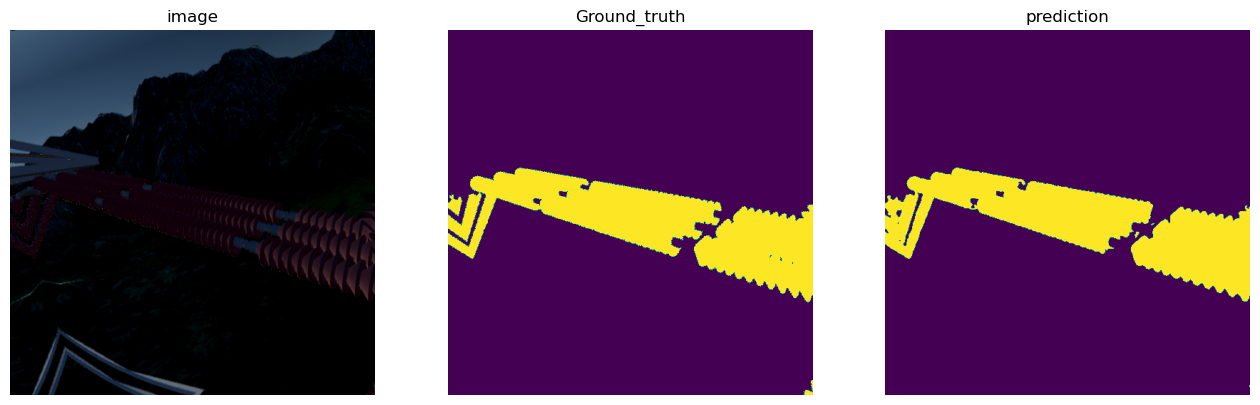

In [40]:
indx = np.random.randint(0, 2)
test_prediction = torch.argmax(y_hat[indx], 0).to('cpu').numpy()
Ground_truth = torch.argmax(y[indx], 0).to('cpu').numpy()
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(16,9))
ax1.imshow(x[indx].to('cpu').numpy().transpose(1,2,0))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(Ground_truth)
ax2.set_title('Ground_truth')
ax2.axis('off')
ax3.imshow(test_prediction)
ax3.set_title("prediction")
ax3.axis('off')


In [41]:

torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/unet_resnet34_polymer.pth')

In [42]:
#load model 
model_path =r'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/unet_resnet34_polymer.pth'
model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
model.load_state_dict(torch.load(model_path))

C:\Users\User\AppData\Local\Temp\ipykernel_2816\1851154591.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [43]:
model.to('cuda')

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [44]:
dir = 'C:/Users/User/Desktop/rakin2/segment/notebook/real_dataset.csv'

In [45]:
transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    # A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    # A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    # A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
], is_check_shapes=False)

In [46]:
real_data = SegmentDataset(dir,2,transform=transform )

In [47]:
real_dataloader = torch.utils.data.DataLoader(real_data, batch_size=10, shuffle=True)

In [48]:
#images, masks = next(iter(real_dataloader))

In [49]:
print(f'sahpe of the image {images.shape} and mask {masks.shape} ,images type {type(images)} and mask type {type(masks)}')

sahpe of the image torch.Size([2, 3, 512, 512]) and mask torch.Size([2, 2, 512, 512]) ,images type <class 'torch.Tensor'> and mask type <class 'torch.Tensor'>


In [50]:
#model.eval()
#real_predictions = []

#with torch.no_grad():
    #for images, masks in tqdm(real_dataloader):
        #images = images.to('cuda')
        #masks = masks.to('cuda')
        #outputs = model(images)
        #preds = torch.argmax(outputs, dim=1)
        #0+.
#real_predictions.append(preds.cpu().numpy())


In [51]:
plt.figure(figsize=(16, 16))

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

In [52]:
# import matplotlib.pyplot as plt
# random_indx = np.random.randint(0, 1000)
# Select a random index to visualize
# indx = np.random.randint(0, len(images))

# Get the image, ground truth, and prediction
# image = images[indx].to('cpu').numpy().transpose(1, 2, 0)
# ground_truth = torch.argmax(masks[indx], 0).to('cpu').numpy()
# prediction = torch.argmax(outputs[indx], 0).to('cpu').numpy()

# Plot the image, ground truth, and prediction
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
# ax1.imshow(image)
# ax1.set_title('Image')
# ax1.axis('off')
# ax2.imshow(prediction)
# ax2.set_title('Ground Truth')
# ax2.axis('off')
# plt.savefig(f'prediction{random_indx}.png')
# plt.show()